In [80]:
import numpy as np
import matplotlib.pyplot as plt
from qutip import *
import time

In [81]:
def print_quantum_state_as_superposition(state):
    """
    Helper function to print quantum state as superposition of basis functions
    """
    state = state.unit()
    dimension = int(np.log2(state.shape[0]))
    state_vector = state.full().flatten()
    basis_states = ['0', '1']
    
    superposition = []
    for i, amplitude in enumerate(state_vector):
        abs_amplitude = np.abs(amplitude)

        if round(abs_amplitude, 2) > 0:
            sign = '-' if amplitude.real < 0 else '+'
            binary_state = ''.join(basis_states[int(bit)] for bit in f"{i:0{dimension}b}")
            superposition.append(f"{sign} {abs_amplitude:.2f}|{binary_state}⟩")

    # Removing the first sign
    if superposition and superposition[0][0] == '+':
        superposition[0] = superposition[0][2:]

    superposition_str = ' '.join(superposition).replace('+-', '- ')
    
    print(f"|ψ⟩ = {superposition_str}")

In [82]:
X = sigmax()
Z = sigmaz()
Y = sigmay()
I = qeye(2)

S_X = tensor(X, X, X, X)
S_Z = tensor(Z, Z, Z, Z)

X_L_1 = tensor(X, I, X, I)
Z_L_1 = tensor(Z, Z, I, I)

X_L_2 = tensor(X, X, I, I)
Z_L_2 = tensor(Z, I, Z, I)


# Logical states
logical_zero = (tensor(basis(2, 0), basis(2, 0), basis(2, 0), basis(2, 0)) +
                tensor(basis(2, 1), basis(2, 1), basis(2, 1), basis(2, 1))).unit()
logical_one = X_L_1 * logical_zero

In [155]:
T = 10
times = np.linspace(0, T, 99)
sigma = 1
omega_max = 10
omega_t = lambda t: omega_max * np.exp(-0.5 * ((t - T/2) / sigma) ** 2)
delta_t = lambda t: 2*omega_max*(t / (T/2) - 1)


In [178]:
def H(t):
    """
    Rapid Adiabatic Hamiltonian
    """
    return  X_L_1 * omega_t(t) + Z_L_1 * delta_t(t)

def H_error_gaussian(t, error_time, strength):
    """
    Error Hamiltonian localized at a specific time (e.g., bit-flip on the first qubit).
    """
    error_width = 0.5
    f_t = strength * np.exp(-((t - error_time) ** 2) / (2 * error_width ** 2))
    return f_t * tensor(X, I, I, I)

def H_error(t, error_time, strength, duration=2):
    if error_time <= t < error_time + duration:
        return strength * tensor(I, X, I, I)
    else:
        return tensor(I, I, I, I)  # Identity

def H_supp(x, z, nu1, nu2, lambda1, lambda2, opt):
    X_A = tensor(X, X, I, I)
    Z_A = tensor(Z, I, Z, I)
    H_supp_stab = S_X + S_Z
    H_supp_gauge = -(lambda1 + lambda2*x) * X_A -(nu1 + nu2*z) * Z_A
    if opt == 'stab':
        return H_supp_stab
    elif opt == 'gauge':
        return H_supp_gauge
    else:
        raise ValueError
    
def H_total(t, error_time, error_strength, duration, x, z, nu1, nu2, lambda1, lambda2, opt, Ep):
    """
    Total Hamiltonian including AQC evolution and error simulation.
    """
    H_n = (H(t) + Ep * H_supp(x, z, nu1, nu2, lambda1, lambda2, opt)) * H_error(t, error_time, error_strength, duration)
    return H_n


In [192]:
lambda1 = 1
lambda2 = 1
nu1 = 1
nu2 = 1
x = -1
z = 1
Ep = -5000
error_time = 7
duration = 3
error_strength = 1
opt = 'gauge'

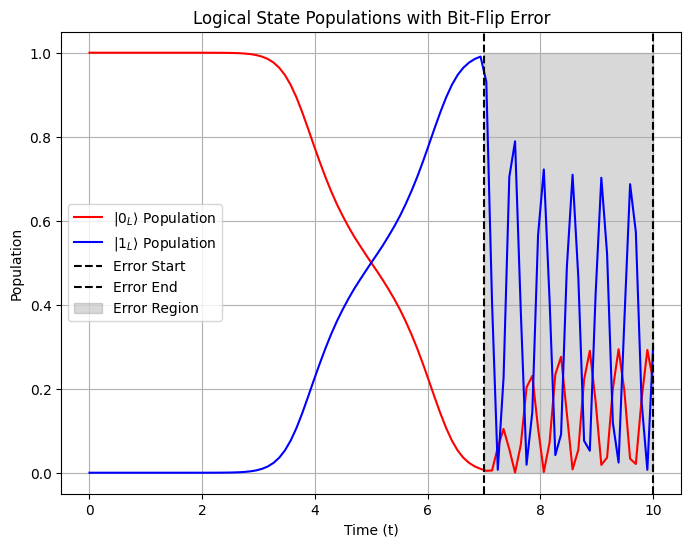

In [193]:
# Simulate evolution
e_ops = [logical_zero*logical_zero.dag(), logical_one*logical_one.dag()]

result = sesolve(lambda t: H_total(t, error_time, error_strength, duration, x, z, nu1, nu2, lambda1, lambda2, opt, Ep),
                 logical_zero, times, e_ops=e_ops, 
                 options={'nsteps': 1e5})

plt.figure(figsize=(8, 6))
plt.plot(times, result.expect[0], label=r"$|0_L\rangle$ Population", color='red')
plt.plot(times, result.expect[1], label=r"$|1_L\rangle$ Population", color='blue')
# Add vertical lines for the start and end of the error
plt.axvline(error_time, color='black', linestyle='--', label="Error Start")
plt.axvline(error_time + duration, color='black', linestyle='--', label="Error End")

# Shade the area between the lines
plt.fill_betweenx(
    [0, 1],  # Adjust y-limits based on your data range
    error_time,
    error_time + duration,
    color='gray',
    alpha=0.3,
    label="Error Region"
)

plt.xlabel("Time (t)")
plt.ylabel("Population")
plt.title("Logical State Populations with Bit-Flip Error")
plt.legend()
plt.grid()
plt.show()